In [ ]:
#Data:
#https://1drv.ms/u/s!AoIY5nWegidXgfsinZOwr8F5Q5j58Q?e=UlYoa7

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from lightgbm import LGBMRegressor

In [2]:
train = pd.read_csv('tabular-playground-series-jul-2021/train.csv')
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [3]:
test = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')
test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [4]:
train.shape, test.shape

((7111, 12), (2247, 9))

In [5]:
train.isnull().sum()

date_time                 0
deg_C                     0
relative_humidity         0
absolute_humidity         0
sensor_1                  0
sensor_2                  0
sensor_3                  0
sensor_4                  0
sensor_5                  0
target_carbon_monoxide    0
target_benzene            0
target_nitrogen_oxides    0
dtype: int64

In [6]:
train_date = train.date_time
test_date = test.date_time

In [7]:
# separate target variables
target_vars = train[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

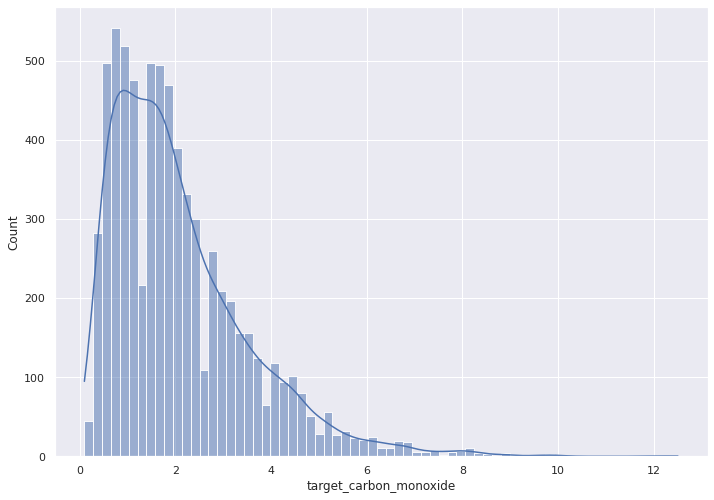

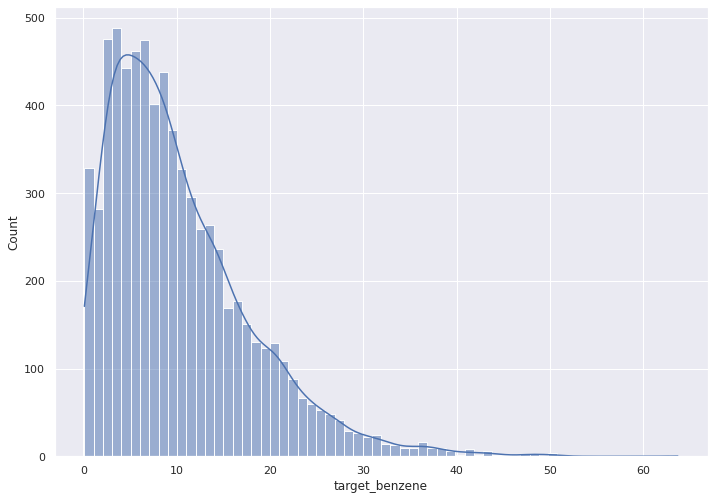

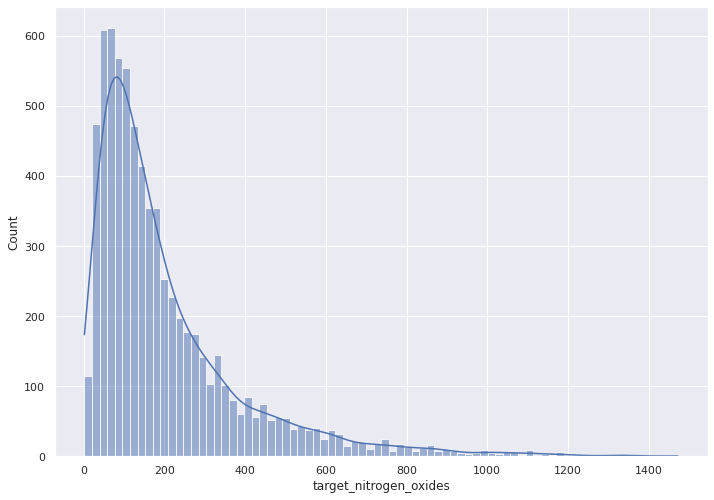

In [8]:
# check for target_vars distribution
for col in target_vars.columns:
    sns.histplot(x=col, data=train, kde=True)
    plt.show()

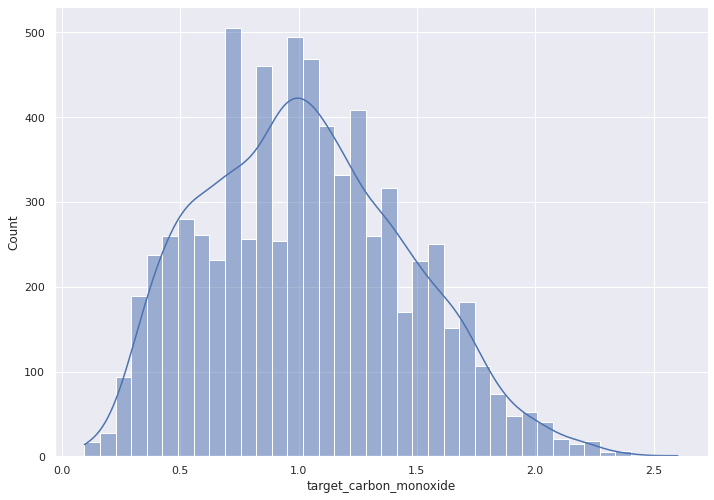

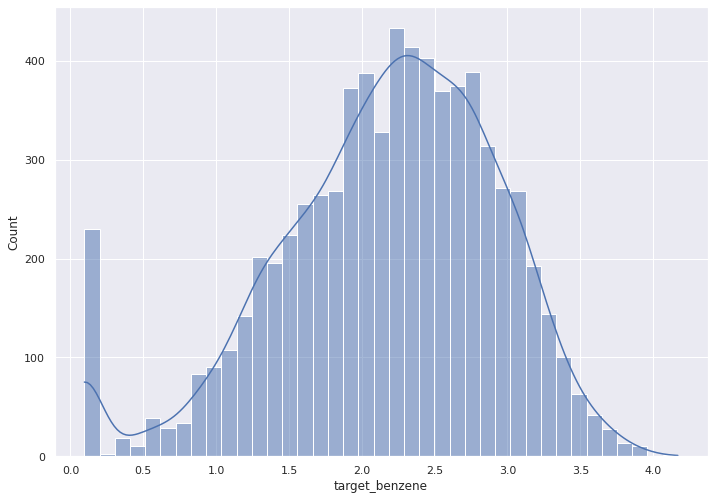

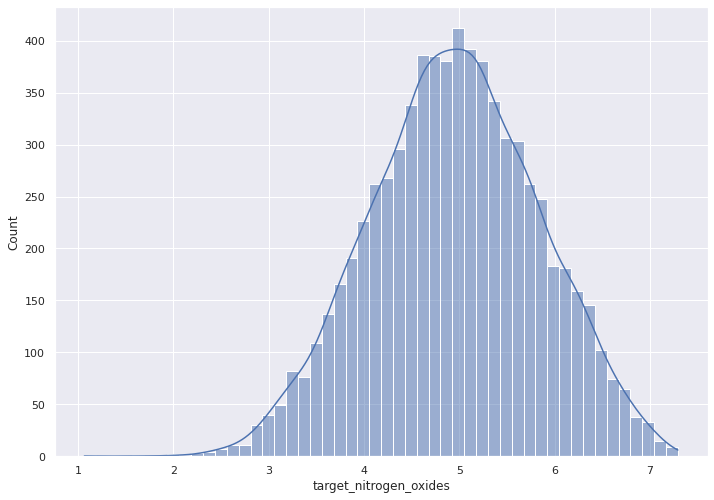

In [9]:
# log1p normalizing target_vars
for target_var in target_vars.columns:
    train[target_var] = np.log1p(train[target_var])
    
for col in target_vars.columns:
    sns.histplot(x=col, data=train, kde=True)
    plt.show()

In [10]:
# get shape of rows to separate train data from all data in future
ntrain = train.shape[0]

# create a target_vars columns in test data and fill it with NaN to create all_data
for target_var in target_vars:
    test[target_var] = np.NaN

# train data + test data
all_data = pd.concat([train, test])

# make sure we haven't lost data
print('The size of a train dataset is:', train.shape)
print('The size of a test dataset is:', test.shape)
print('The size of both train and test datasets:', all_data.shape)

The size of a train dataset is: (7111, 12)
The size of a test dataset is: (2247, 12)
The size of both train and test datasets: (9358, 12)


<AxesSubplot:>

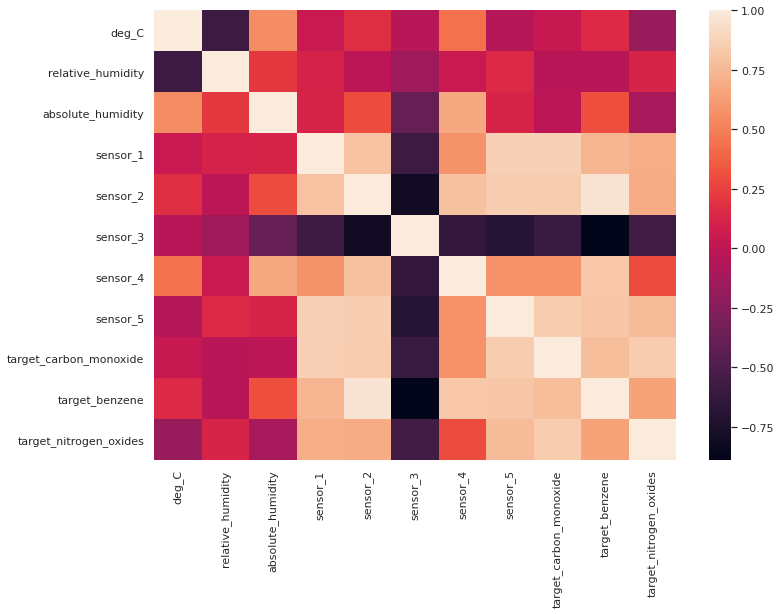

In [11]:
sns.heatmap(all_data.corr())

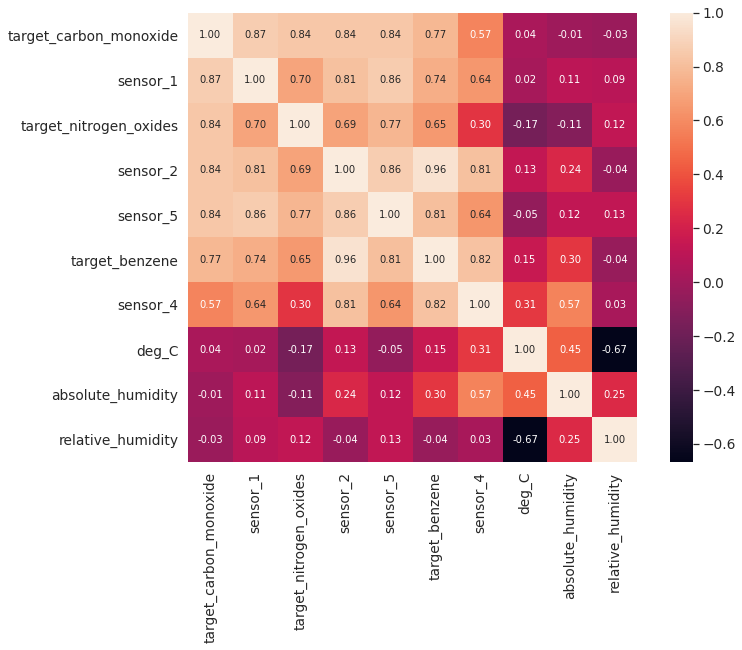

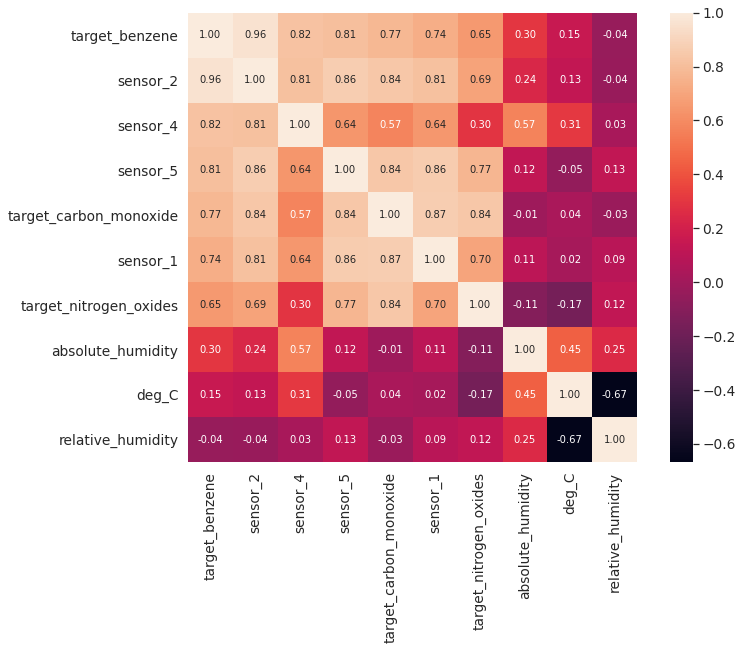

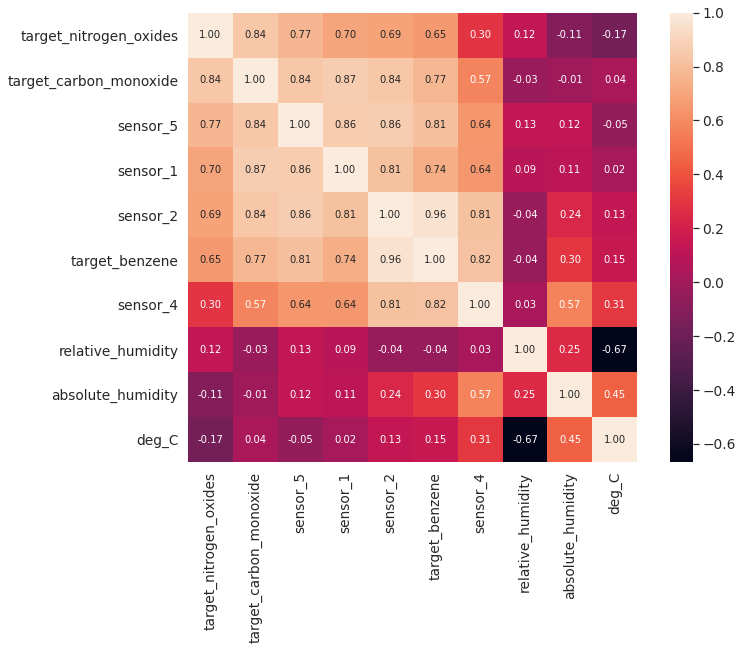

In [12]:
corrmat = all_data.corr()
k = 10 
for col in target_vars.columns:
    cols = corrmat.nlargest(k, col)[col].index
    cm = np.corrcoef(train[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

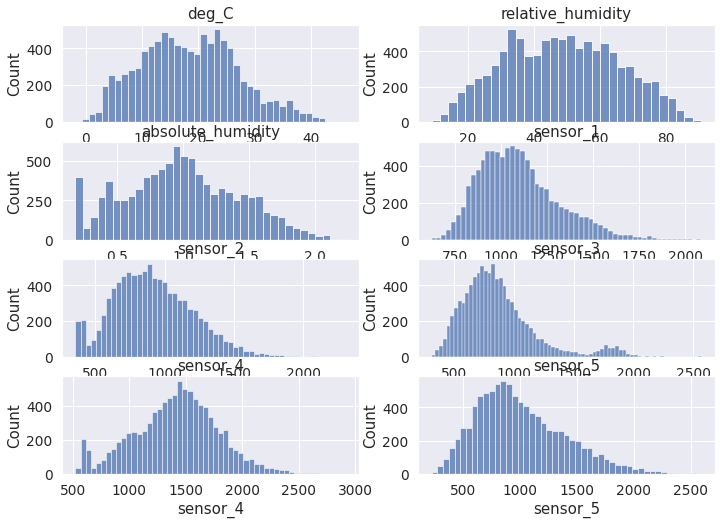

In [13]:
for i, col in enumerate(all_data.columns[1:-3]):
    plt.subplot(4, 2, i + 1)
    sns.histplot(x=col, data=all_data)
    plt.title(col)

In [14]:
# a little feature engineering with time
date =  pd.to_datetime(all_data.date_time)
all_data['hour'] = date.dt.hour
all_data['is_weekend'] = date.dt.day_name().isin(['Saturday', 'Sunday'])*1
all_data['working_hours'] = all_data['hour'].isin(np.arange(8, 21, 1)).astype('int')
all_data.drop('hour', axis=1, inplace=True)

In [15]:
def date_time_encoding(f_name, f_itself, max_val):
        all_data['sin_' + f_name] = np.sin(2 * np.pi * (f_itself/max_val))
        all_data['cos_' + f_name] = np.cos(2 * np.pi * (f_itself/max_val))
        all_data['tan_' + f_name] = np.tan(2 * np.pi * (f_itself/max_val))

In [16]:
datetime = pd.to_datetime(all_data['date_time'])
date = pd.DataFrame(datetime.dt.month)
day  = pd.DataFrame(datetime.dt.day)
time = pd.DataFrame(datetime.dt.hour)

In [17]:
date_time_encoding('time', time, 24)
date_time_encoding('date', date, 12)
date_time_encoding('day' , day,  31)

In [18]:
all_data.drop('date_time', axis=1, inplace=True)

In [19]:
# separating train and test data
X_train = all_data[:ntrain].drop(target_vars, axis=1)
X_test = all_data[ntrain:].drop(target_vars, axis=1)

In [20]:
# make sure we didn't miss anything 
print('The size of a train dataset is:', X_train.shape)
print('The size of a test dataset is:', X_test.shape)
print('The size of both datasets:', all_data.shape)

The size of a train dataset is: (7111, 19)
The size of a test dataset is: (2247, 19)
The size of both datasets: (9358, 22)


In [21]:
y_1 = all_data['target_carbon_monoxide'][:ntrain]
y_2 = all_data['target_benzene'][:ntrain]
y_3 = all_data['target_nitrogen_oxides'][:ntrain]

In [22]:
# make sure to make sure
print('The size of the target_carbon_monoxide vector is:', y_1.shape[0])
print('The size of the target_benzene vector is:', y_2.shape[0])
print('The size of the target_nitrogen_oxides vector is', y_3.shape[0])
print('The size of the X_train is:', X_train.shape[0])

The size of the target_carbon_monoxide vector is: 7111
The size of the target_benzene vector is: 7111
The size of the target_nitrogen_oxides vector is 7111
The size of the X_train is: 7111


In [23]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train,
                                                              y_1,
                                                              test_size=0.3,
                                                              random_state=17)

In [24]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train,
                                                              y_2,
                                                              test_size=0.3,
                                                              random_state=17)

In [25]:
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X_train,
                                                              y_3,
                                                              test_size=0.3,
                                                              random_state=17)

In [26]:
# creating lgbm model (params were found with GridSearchCV)
lgbm = LGBMRegressor(random_state=17,
                       max_depth=11,
                       n_estimators=500,
                       num_leaves=45,
                       subsample=0.7,
                       verbosity=-1)

# GridSearchCV for learning rate
lgbm_learning_rate = {'learning_rate': np.logspace(-3, 0, 10)}

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=lgbm_learning_rate, cv=5, verbose=1, n_jobs=-1)

In [27]:
# model for carbon_monoxide
grid_search_lgbm.fit(X_train_1, y_train_1)
best_lgbm_1 = grid_search_lgbm.best_estimator_
print('Mean Squared Error for carbon_monoxide: ', mean_squared_error(y_valid_1, best_lgbm_1.predict(X_valid_1)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.5s finished


Mean Squared Error for carbon_monoxide:  0.009479632345469828


In [28]:
# model for benzene
grid_search_lgbm.fit(X_train_2, y_train_2)
best_lgbm_2 = grid_search_lgbm.best_estimator_
print('Mean Squared Error for benzene: ', mean_squared_error(y_valid_2, best_lgbm_2.predict(X_valid_2)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.9s finished


Mean Squared Error for benzene:  0.007152730764700737


In [29]:
# model for nitrogen_oxides
grid_search_lgbm.fit(X_train_3, y_train_3)
best_lgbm_3 = grid_search_lgbm.best_estimator_
print('Mean Squared Error for nitrogen_oxides: ', mean_squared_error(y_valid_3, best_lgbm_3.predict(X_valid_3)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.7s finished


Mean Squared Error for nitrogen_oxides:  0.03724380509923477


In [30]:
# transforming target_vars from log and making preds 
lgbm_pred_1 = np.expm1(best_lgbm_1.predict(X_test))
lgbm_pred_2 = np.expm1(best_lgbm_2.predict(X_test))
lgbm_pred_3 = np.expm1(best_lgbm_3.predict(X_test))

In [31]:
# create dataframe and save data
sub = pd.DataFrame()
sub['date_time'] = test_date
sub['target_carbon_monoxide'] = lgbm_pred_1
sub['target_benzene'] = lgbm_pred_2
sub['target_nitrogen_oxides'] = lgbm_pred_3
sub.to_csv('submission_1.csv',index=False)

In [32]:
sub

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.432255,4.538519,199.538891
1,2011-01-01 01:00:00,1.842184,7.158417,282.403585
2,2011-01-01 02:00:00,1.644842,6.848773,260.172510
3,2011-01-01 03:00:00,2.043189,7.926435,300.282945
4,2011-01-01 04:00:00,1.093235,6.278808,198.693715
...,...,...,...,...
2242,2011-04-04 10:00:00,2.527223,13.307542,245.510888
2243,2011-04-04 11:00:00,2.330398,11.167219,168.375894
2244,2011-04-04 12:00:00,2.410867,12.922227,162.513843
2245,2011-04-04 13:00:00,1.931976,11.229205,111.950798
